In [45]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training/validation and test data. NOTE: The files from with these data came were too large to be stored on gitHub.

In [46]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

assert training_val_data.shape == (204792, 62)
assert test_data.shape == (55311, 61)
assert 'Sale Price' in training_val_data.columns.values
assert 'Sale Price' not in test_data.columns.values

In [47]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

## Preparing Data


Let's split the dataset into a training set and validation set.

In [71]:
def train_val_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split = int(0.8*len(shuffled_indices))
    train_indices = shuffled_indices[0:split]
    validation_indices = shuffled_indices[split:]
    train = data.loc[train_indices, :]
    validation = data.loc[validation_indices, :]
   
    return train, validation
train, validation = train_val_split(training_val_data)

## Useful Setup

Below I copy over a few useful functions from part I of this project.

In [72]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] > lower) & (data[variable] <= upper), :]

def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = with_rooms["Description"].str.extract(r"(\d+) of which are bedrooms").astype(int)
    return with_rooms

def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = data.groupby("Neighborhood Code").agg(metric).sort_values("Log Sale Price").nlargest(n, "Log Sale Price").index
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data["Neighborhood Code"].isin(neighborhoods).astype(int)
    return data

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """

    cat = ["Roof Material"]
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])
    oh_enc_df = pd.DataFrame(data=oh_enc.transform(data[cat]).toarray(), columns=oh_enc.get_feature_names_out(), index=data.index)
    return data.join(oh_enc_df)

I've written a function to compute the RMSE of the model we'll ultimately use.

In [73]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

I've also written a function to one hot encode categorical variables and incorporate them in a dataframe without the original categorical columns! This will come very handy.

In [74]:
def one_hot_encode(data, cat):
    """
    Return the one-hot encoded dataframe of our input data, removing redundancies.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    cat: columns to one-hot-encode
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features without any redundancies.
    
    """
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[cat])
    oh_enc_df = pd.DataFrame(data=oh_enc.transform(data[cat]).toarray(), columns=oh_enc.get_feature_names_out(), index=data.index)
    dat = data.join(oh_enc_df)
    return dat.drop(columns=cat)

## Constructing the Model

Below I've isolated the features I will use for this multilinnear regression model. cat_ohe are categorical features that I one hot encode. The cat_log features are ones whose relations best match Log Sale Price when I take the logarithm of them. The cat_oth features I don't need to do anything additional to.

In [75]:
cat_oth = ["Bedrooms"]
cat_log = ["Land Square Feet", "Building Square Feet", "Estimate (Land)", "Estimate (Building)"]
cat_ohe = ["Construction Quality", "Roof Material", "Wall Material", "Repair Condition", "Garage 1 Size"]

Next, I construct a multilinear regression model using these features.

In [76]:
def model_constructor(data):
    dat = add_total_bedrooms(data)
    
    #features that are used and predictor
    kept_cols = cat_oth+cat_ohe+["Log Sale Price"]

    dat['Log Sale Price'] = np.log(dat['Sale Price'])
    #Adding features on a log scale to dataset 
    for cat in cat_log:
        feature = "Log" + cat
        dat[feature] = np.log(dat[cat]+1)
        kept_cols.append(feature)
    dat = dat.drop(columns=[col for col in data.columns if col not in kept_cols])
    
    #One hot encoding categorical features
    dat = one_hot_encode(dat, cat_ohe)
    
    dat = dat.fillna(0)
    X = dat.drop(columns=["Log Sale Price"])
    model = lm.LinearRegression(fit_intercept=True)
    model.fit(X, dat["Log Sale Price"])
    
    return X, model

In [77]:
train_copy = remove_outliers(train, "Sale Price", lower=500)
X, model = model_constructor(train_copy)

## Predictions with the Model

Below, I write a function to make predictions on data (whose outliers have already been removed).

In [78]:
def model_fit(data, model):
    dat = add_total_bedrooms(data)
    
    #features that are used and predictor
    kept_cols = cat_oth+cat_ohe+["Log Sale Price"]

    dat['Log Sale Price'] = np.log(dat['Sale Price'])
    #Adding features on a log scale to dataset 
    for cat in cat_log:
        feature = "Log" + cat
        dat[feature] = np.log(dat[cat]+1)
        kept_cols.append(feature)
    dat = dat.drop(columns=[col for col in data.columns if col not in kept_cols])
    
    #One hot encoding categorical features
    dat = one_hot_encode(dat, cat_ohe)
    
    dat = dat.fillna(0)
    return model.predict(dat.drop(columns=["Log Sale Price"]))

I start by making predictions on my training set. The rmse shown represents the error in predicting the sale price on a log scale.

In [79]:
y1 = model_fit(train_copy, model)
rmse(y1, np.log(train_copy["Sale Price"]))

0.6623038347944189

Next, I make predictions on my validation set. The rmse shown represents the error in predicting the Sale Price. The error is around 210,000. For homes with value on the order of 10^7, this is a more reasonable error. For homes on the value of 10^3, not so much. Let's take a look at where this error is coming from!

In [83]:
valid_copy = remove_outliers(validation, "Sale Price", lower=500)
y2 = model_fit(valid_copy, model)
rmse(np.exp(y2), valid_copy["Sale Price"])

210514.7595166608

## Final Note

<AxesSubplot:xlabel='Sale Price', ylabel='Residual'>

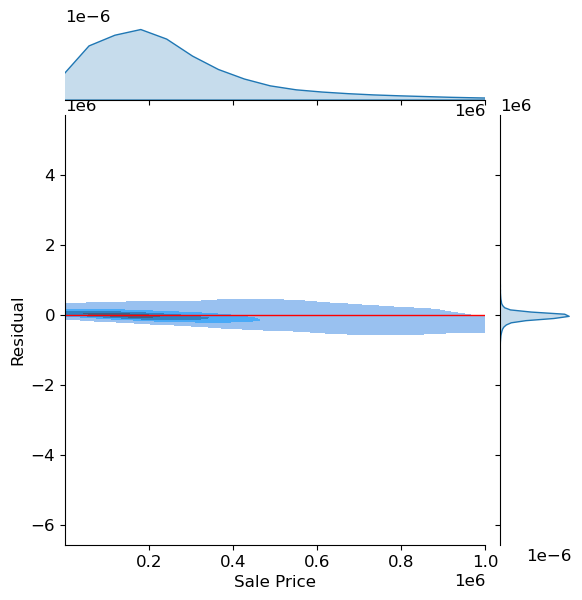

In [85]:
dat = pd.DataFrame(data={"Sale Price": valid_copy["Sale Price"], "Residual": (np.exp(y2)-valid_copy["Sale Price"])})
graph = sns.jointplot(data=dat, x="Sale Price", y="Residual", kind="kde", fill=True, n_levels=5, xlim=(500, 1000000))
sns.lineplot([500, 1000000], [0, 0], color='red', ax=graph.ax_joint, linewidth=1)

Above, I've constructed a plot that demonstrated how far off my model's estimates of the sale price were. Points above the y=0 axhline are overestimates of the sale price, points below are underestimates. There are a few key promising features about this plot. First, the distribution is evenly spread about zero. This indicates low systematic error in the model. Second, particularly for lower sale prices, the residuals are not as large. This means that basing real estate tax off of this model would not be regressive, as it was in the model Cook County was using for its residents!